# CHEK2 boostDM-CH drivers compared to expert curated rules
# VAF < 0.25

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

## 1. Upload data

In [2]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")

### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)

# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

/tmp/jobs/jramis/9874679/ipykernel_3073/1437940864.py:7: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


203351

## 2. Generate new variables with high-confidence drivers and filter VAF <0.25

In [3]:
### Filter by VAF<0.25
boostDM_predictions = boostDM_predictions[boostDM_predictions['VAF_alt']<0.25]

### Transform the variable 'Drivers_12genes' in a new prediction of high-confidence drivers
boostDM_predictions['Drivers_12genes'] = np.where(boostDM_predictions['boostDM_score']>=0.9, 1, 0)
len(boostDM_predictions)

152169

In [4]:
# list of patients with potential CH mutation
patients_potentialCH = boostDM_predictions['patient'].to_list()
print(len(patients_potentialCH))
patients_potentialCH_big = boostDM_predictions[boostDM_predictions['VAF_alt']>=0.10]['patient'].to_list()
print(len(patients_potentialCH_big))
patients_potentialCH_small = boostDM_predictions[boostDM_predictions['VAF_alt']<0.10]['patient'].to_list()
print(len(patients_potentialCH_small))

152169
14667
137502


In [5]:
# list of patients with BoostDM driver
patients_CHdrivers = boostDM_predictions[boostDM_predictions['Drivers_12genes'] == 1]['patient'].to_list()
print(len(patients_CHdrivers))
patients_CHdrivers_big = boostDM_predictions[(boostDM_predictions['Drivers_12genes']==1) & (boostDM_predictions['VAF_alt']>=0.10)]['patient'].to_list()
print(len(patients_CHdrivers_big))
patients_CHdrivers_small = boostDM_predictions[(boostDM_predictions['Drivers_12genes']==1) & (boostDM_predictions['VAF_alt']<0.10)]['patient'].to_list()
print(len(patients_CHdrivers_small))

27460
5406
22054


In [6]:
# list of patients with BoostDM passengers
patients_CH_passengers = boostDM_predictions[boostDM_predictions['Drivers_12genes'] == 0]['patient'].to_list()
print(len(patients_CH_passengers))
patients_CH_passengers_big = boostDM_predictions[(boostDM_predictions['Drivers_12genes']==0) & (boostDM_predictions['VAF_alt']>=0.10)]['patient'].to_list()
print(len(patients_CH_passengers_big))
patients_CH_passengers_small = boostDM_predictions[(boostDM_predictions['Drivers_12genes']==0) & (boostDM_predictions['VAF_alt']<0.10)]['patient'].to_list()
print(len(patients_CH_passengers_small))

124709
9261
115448


In [7]:
patient_age_ch['CH_driver'] = np.where(patient_age_ch['patient'].isin(patients_CHdrivers), 1, 0)
patient_age_ch['CH_driver'].value_counts()

0    443955
1     25925
Name: CH_driver, dtype: int64

In [8]:
# Add to table num of drivers
patient_age_ch['CH_driver_big'] = np.where(patient_age_ch['patient'].isin(patients_CHdrivers_big), 1, 0)
patient_age_ch['CH_driver_big'].value_counts()

0    464623
1      5257
Name: CH_driver_big, dtype: int64

In [9]:
# Add to table num of drivers
patient_age_ch['CH_driver_small'] = np.where(patient_age_ch['patient'].isin(patients_CHdrivers_small), 1, 0)
patient_age_ch['CH_driver_small'].value_counts()

0    448823
1     21057
Name: CH_driver_small, dtype: int64

In [10]:
#Add cases with potential CH mutations
patient_age_ch['CH_potential'] = np.where(patient_age_ch['patient'].isin(patients_potentialCH), 1, 0)
patient_age_ch['CH_potential'].value_counts()

0    356813
1    113067
Name: CH_potential, dtype: int64

In [11]:
#Add cases with potential
patient_age_ch['CH_passengers'] = np.where(patient_age_ch['patient'].isin(patients_CH_passengers), 1, 0)
patient_age_ch['CH_passengers'].value_counts()

0    375791
1     94089
Name: CH_passengers, dtype: int64

In [12]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/tmp/jobs/jramis/9874679/ipykernel_3073/1383614074.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [13]:
# Add num of drivers
patient_age_ch['num_CH_potential'] = patient_age_ch['patient'].progress_apply(lambda x: patients_potentialCH.count(x) if x in patients_potentialCH else 0)
patient_age_ch['num_CH_potential'].value_counts()

  0%|          | 0/469880 [00:00<?, ?it/s]

In [33]:
genes12 = ['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']

In [34]:
# Get patients with CH mutation in the gene

for i in genes12:
    
    gene_CH_patient = boostDM_predictions[boostDM_predictions['SYMBOL'] == i]
    
    gene_CH_patient_drivers = set(gene_CH_patient[gene_CH_patient['Drivers_12genes'] == 1]['patient'].to_list())
    patient_age_ch[i+'_driver'] = np.where(patient_age_ch['patient'].isin(gene_CH_patient_drivers), 1, 0)
    
    gene_CH_patient_passengers = set(gene_CH_patient[gene_CH_patient['Drivers_12genes'] == 0]['patient'].to_list())
    patient_age_ch[i+'_passenger'] = np.where(patient_age_ch['patient'].isin(gene_CH_patient_passengers), 1, 0)

    gene_CH_patient_potential = set(gene_CH_patient['patient'].to_list())
    patient_age_ch[i+'_potential'] = np.where(patient_age_ch['patient'].isin(gene_CH_patient_potential), 1, 0)
    
patient_age_ch

# check
for i in genes12:
    print(i, sum(patient_age_ch[i+'_driver']), sum(patient_age_ch[i+'_passenger']), sum(patient_age_ch[i+'_potential']))

In [16]:
# Annotate cancer variables again

In [35]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)

# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

## 3. New boostDM-CH driver analysis

In [36]:
# Remove mutations from cases with prior hematologic cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)].reset_index(drop=True)
len(boostDM_predictions_nonHN)

In [37]:
#Remove cases with prior hemathological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
ukb200K_ch_cancer_logistic.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
len(ukb200K_ch_cancer_logistic)

In [38]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t')
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str)+'-'+Rules_matrix['pos'].astype(str)+'-'+ Rules_matrix['alt'].astype(str)
Rules_matrix

In [39]:
#Select mutations based on driver call
BoostDM_dirvers = Rules_matrix[Rules_matrix['boostDM_class']==1]
Niroula_dirvers = Rules_matrix[Rules_matrix['Niroula']==1]
Bick_dirvers = Rules_matrix[Rules_matrix['Bick']==1]
WHO_dirvers = Rules_matrix[Rules_matrix['WHO']==1]

boostDM_predictions['BoostDM'] = np.where(boostDM_predictions['ID2'].isin(BoostDM_dirvers['ID2'].to_list()), 1, 0)
print('BoostDM_Done')
boostDM_predictions['Niroula'] = np.where(boostDM_predictions['ID2'].isin(Niroula_dirvers['ID2'].to_list()), 1, 0)
print('Niroula_Done')
boostDM_predictions['Bick'] = np.where(boostDM_predictions['ID2'].isin(Bick_dirvers['ID2'].to_list()), 1, 0)
print('Bick_Done')
boostDM_predictions['WHO'] = np.where(boostDM_predictions['ID2'].isin(WHO_dirvers['ID2'].to_list()), 1, 0)
print('WHO_Done')

In [40]:
ukb_boostDM_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&\
                                                       (boostDM_predictions['Niroula']==0)&\
                                                      (boostDM_predictions['Bick']==0)&\
                                                      (boostDM_predictions['WHO']==0)]['ID2'].to_list()
boostDM_predictions['BoostDM_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_boostDM_exc), 1, 0)


ukb_Niroula_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                    (boostDM_predictions['Niroula']==1)]['ID2'].to_list()
boostDM_predictions['Niroula_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_Niroula_exc), 1, 0)


ukb_Bick_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                 (boostDM_predictions['Bick']==1)]['ID2'].to_list()
boostDM_predictions['Bick_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_Bick_exc), 1, 0)



ukb_WHO_exc = boostDM_predictions[(boostDM_predictions['BoostDM']==0)&\
                                (boostDM_predictions['WHO']==1)]['ID2'].to_list()
boostDM_predictions['WHO_exc'] = np.where(boostDM_predictions['ID2'].isin(ukb_WHO_exc), 1, 0)


ukb_Overlap_all = boostDM_predictions[(boostDM_predictions['BoostDM']==1)&\
                                                       (boostDM_predictions['Niroula']==1)&\
                                                      (boostDM_predictions['Bick']==1)&\
                                                      (boostDM_predictions['WHO']==1)]['ID2'].to_list()
boostDM_predictions['Overlap_all'] = np.where(boostDM_predictions['ID2'].isin(ukb_Overlap_all), 1, 0)



Overlapping_1 = boostDM_predictions[((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==1))]['ID2'].to_list()
boostDM_predictions['Overlapping_1'] = np.where(boostDM_predictions['ID2'].isin(Overlapping_1), 1, 0)


Overlapping_2 = boostDM_predictions[((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==0))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==0)&\
                                           (boostDM_predictions['Bick']==1)&\
                                           (boostDM_predictions['WHO']==1))|\
                                           
                                           ((boostDM_predictions['BoostDM']==1)&\
                                           (boostDM_predictions['Niroula']==1)&\
                                           (boostDM_predictions['Bick']==0)&\
                                           (boostDM_predictions['WHO']==1))]['ID2'].to_list()
boostDM_predictions['Overlapping_2'] = np.where(boostDM_predictions['ID2'].isin(Overlapping_2), 1, 0)

In [41]:
#Select mutations based on driver call

patients_CHdrivers_Over = boostDM_predictions[boostDM_predictions['Overlap_all'] == 1]['patient'].to_list()
patients_CHdrivers_Over1 = boostDM_predictions[boostDM_predictions['Overlapping_1'] == 1]['patient'].to_list()
patients_CHdrivers_Over2 = boostDM_predictions[boostDM_predictions['Overlapping_2'] == 1]['patient'].to_list()
patients_CHdrivers_BoostDM = boostDM_predictions[boostDM_predictions['BoostDM_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Niroula = boostDM_predictions[boostDM_predictions['Niroula_exc'] == 1]['patient'].to_list()
patients_CHdrivers_Bick = boostDM_predictions[boostDM_predictions['Bick_exc'] == 1]['patient'].to_list()
patients_CHdrivers_WHO = boostDM_predictions[boostDM_predictions['WHO_exc'] == 1]['patient'].to_list()

ukb200K_ch_cancer['Potentiall_all'] = np.where(ukb200K_ch_cancer['patient'].isin(boostDM_predictions['patient'].to_list()), 1, 0)
ukb200K_ch_cancer['Overlap_all'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over), 1, 0)
ukb200K_ch_cancer['Overlapping_1'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over1), 1, 0)
ukb200K_ch_cancer['Overlapping_2'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Over2), 1, 0)
ukb200K_ch_cancer['BoostDM_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_BoostDM), 1, 0)
ukb200K_ch_cancer['Niroula_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Niroula), 1, 0)
ukb200K_ch_cancer['Bick_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Bick), 1, 0)
ukb200K_ch_cancer['WHO_exc'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_WHO), 1, 0)

patients_CHdrivers_BoostDM = boostDM_predictions[boostDM_predictions['BoostDM'] == 1]['patient'].to_list()
patients_CHdrivers_Niroula = boostDM_predictions[boostDM_predictions['Niroula'] == 1]['patient'].to_list()
ukb200K_ch_cancer['BoostDM'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_BoostDM), 1, 0)
ukb200K_ch_cancer['Niroula'] = np.where(ukb200K_ch_cancer['patient'].isin(patients_CHdrivers_Niroula), 1, 0)

In [42]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']

In [43]:
# Remove cases with multiple mutations
ukb200K_ch_cancer = ukb200K_ch_cancer[ukb200K_ch_cancer['num_CH_potential']<2].reset_index(drop=True)
len(ukb200K_ch_cancer)

In [44]:
# Remove cases with prior hematological cancer
ukb200K_ch_cancer_logistic = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0].reset_index(drop=True)
len(ukb200K_ch_cancer_logistic)

In [45]:
def gene_matrix(mat, gene):
    if gene == 'ASXL1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'CHEK2':
        matrix = mat[(mat['ASXL1_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'DNMT3A':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'GNAS':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'IDH2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'MDM4':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'PPM1D':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SF3B1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'SRSF2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TET2':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'TP53':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['ASXL1_potential']==0) &\
                 (mat['U2AF1_potential']==0)]
    elif gene == 'U2AF1':
        matrix = mat[(mat['CHEK2_potential']==0) &\
                 (mat['DNMT3A_potential']==0) &\
                 (mat['GNAS_potential']==0) &\
                 (mat['IDH2_potential']==0) &\
                 (mat['MDM4_potential']==0) &\
                 (mat['PPM1D_potential']==0) &\
                 (mat['SF3B1_potential']==0) &\
                 (mat['SRSF2_potential']==0) &\
                 (mat['TET2_potential']==0) &\
                 (mat['TP53_potential']==0) &\
                 (mat['ASXL1_potential']==0)]
    return matrix

In [51]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []

ggg = 'CHEK2'

for gene in ['BoostDM', 'CH_driver', 'Niroula', 'Overlapping_1', 'BoostDM_exc', 'Niroula_exc']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()

        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.1 else 'ns' if qval > 0.1 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.010855
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006225
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.003711
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.003602
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.008109
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.000159
         Iterations 20


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM,512,1.011231,1.000195,1.022388,0.046073,0.001507,sig,0.092147
1,CH_driver,271,1.019371,1.003905,1.035075,0.013909,0.002970,sig,0.065822
2,Niroula,151,1.001968,0.982162,1.022173,0.846984,0.004730,ns,0.918405
3,Overlapping_1,146,1.001060,0.980966,1.021567,0.918405,0.004736,ns,0.918405
4,BoostDM_exc,366,1.015378,1.002210,1.028720,0.021941,0.001437,sig,0.065822
5,Niroula_exc,5,1.028403,0.916255,1.154278,0.634500,0.076173,ns,0.918405


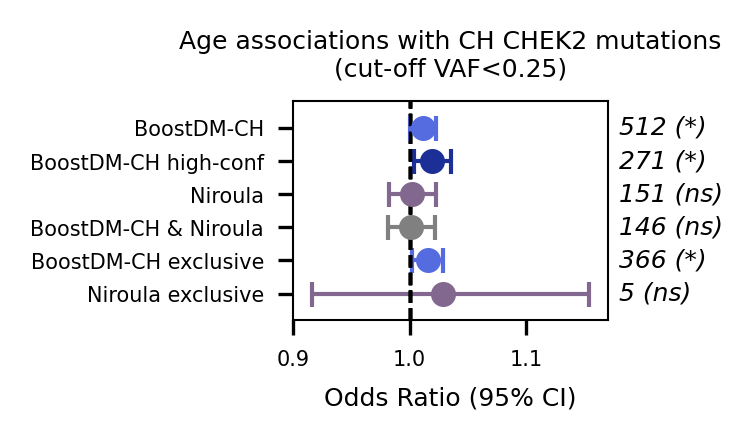

In [52]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3.5, 1.5), dpi=300)
xlimit = 1.17
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'Overlap_all' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_1' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH & Niroula'], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_2' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#555555', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#555555", mec="#555555")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH exclusive'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula_exc':
        plt.errorbar(x=[row['OR']], y=['Niroula exclusive'], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Bick_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#6DAC67", mec="#6DAC67")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'WHO' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EAD36E", mec="#EAD36E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'CH' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH high-conf'], xerr=ci,
                 ecolor='#1C2F96', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#1C2F96", mec="#1C2F96")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, str(row['num_muts'])+' (*)', style='italic', size=6)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=6)
        
        
ax.set_title('Age associations with CH '+ggg+' mutations\n(cut-off VAF<0.25)', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio (95% CI)', fontsize=6)


plt.show()

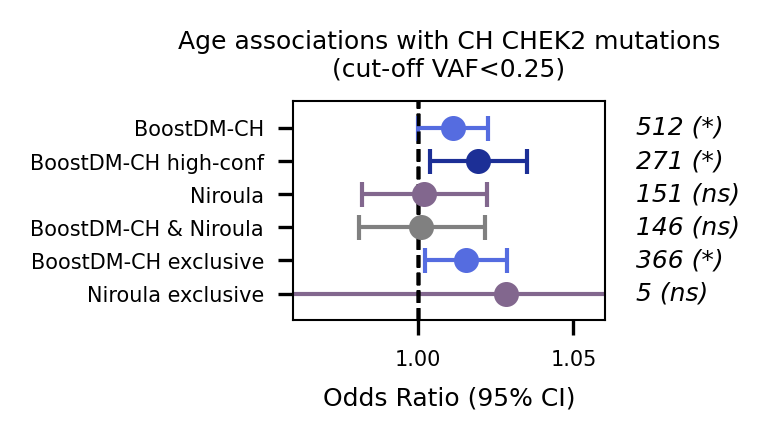

In [53]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(3, 1.5), dpi=300)
xlimit = 1.06
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'Overlap_all' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_1' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH & Niroula'], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_2' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#555555', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#555555", mec="#555555")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH exclusive'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula_exc':
        plt.errorbar(x=[row['OR']], y=['Niroula exclusive'], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Bick_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#6DAC67", mec="#6DAC67")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'WHO' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EAD36E", mec="#EAD36E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'CH' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH high-conf'], xerr=ci,
                 ecolor='#1C2F96', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#1C2F96", mec="#1C2F96")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, str(row['num_muts'])+' (*)', style='italic', size=6)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=6)
        
        
ax.set_title('Age associations with CH '+ggg+' mutations\n(cut-off VAF<0.25)', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.96, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio (95% CI)', fontsize=6)


plt.show()

In [54]:
#perform logistic regression separetly
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as mtc

name = []
OR = []
cilow = []
ciup = []
rsquare = []
pval = []
sig = []
num_muts = []

ggg = 'MDM4'

for gene in ['BoostDM', 'CH_driver']:   
    #we have exclude pre hematological cases
    CH_driver_matrix = ukb200K_ch_cancer_logistic[(ukb200K_ch_cancer_logistic[gene]==1)|(ukb200K_ch_cancer_logistic['Potentiall_all']==0)]
    CH_driver_matrix = gene_matrix(CH_driver_matrix, ggg)
    num_mut = len(CH_driver_matrix[(CH_driver_matrix[gene] == 1)])
    if num_mut > 0:
        model_hematopost = smf.logit(formula= gene+' ~ 1 + age_recruitment_x + sex + PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10', data=CH_driver_matrix).fit()

        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.exp(model_hematopost.params[1]))
        cilow.append(np.exp(model_hematopost.conf_int().iloc[1,0]))
        ciup.append(np.exp(model_hematopost.conf_int().iloc[1,1]))
        rsquare.append(model_hematopost.prsquared)
        pval.append(model_hematopost.pvalues[1])
        sig.append('significant' if model_hematopost.pvalues[1] <= 0.05 else 'not significant')
    else:
        name.append(gene)
        num_muts.append(num_mut)
        OR.append(np.nan)
        cilow.append(np.nan)
        ciup.append(np.nan)
        rsquare.append(np.nan)
        pval.append(np.nan)
        sig.append(np.nan)

varlist = pd.DataFrame(list(zip(name, num_muts, OR, cilow, ciup, pval, rsquare, sig)), columns = ['gene','num_muts' , 'OR', 'Lower CI', 'Upper CI', 'pval', 'rsquare', 'sig'])

import math
q_value = []
q_val = mtc.fdrcorrection(pd.to_numeric(varlist[~varlist['pval'].isna()]['pval']))[1]
num_pval = -1
for x in varlist.pval:
    if math.isnan(x):
        q_value.append(np.nan)
    else:
        num_pval=num_pval+1
        q_value.append(q_val[num_pval])
varlist["q_value"] = q_value
varlist['sig'] = ['sig' if qval <= 0.1 else 'ns' if qval > 0.1 else np.nan for qval in varlist.q_value]
varlist

Optimization terminated successfully.
         Current function value: 0.001361
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.001361
         Iterations 17


,gene,num_muts,OR,Lower CI,Upper CI,pval,rsquare,sig,q_value
0,BoostDM,50,1.043339,1.004898,1.083251,0.026756,0.021378,sig,0.026756
1,CH_driver,50,1.043339,1.004898,1.083251,0.026756,0.021378,sig,0.026756


/tmp/jobs/jramis/9874679/ipykernel_3073/3101869693.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


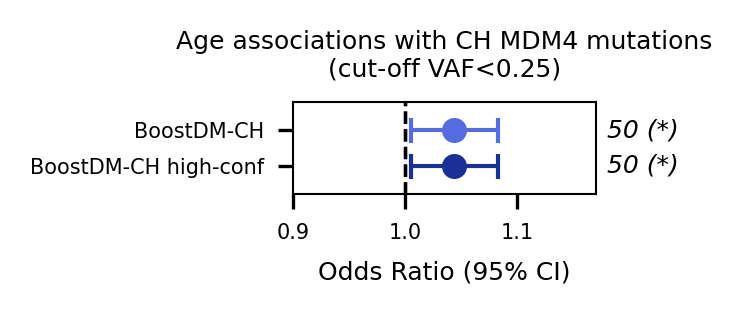

In [55]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(1.3, 0.4), dpi=300)
xlimit = 1.17
ylimit = len(varlist)-1

for idx, row in varlist.iloc[::-1].iterrows():
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]
    if 'Overlap_all' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#333333', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#333333", mec="#333333")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_1' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH & Niroula'], xerr=ci,
                 ecolor='grey', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="grey", mec="grey")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'Overlapping_2' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#555555', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#555555", mec="#555555")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'BoostDM':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula':
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
            
    elif row['gene'] == 'BoostDM_exc':
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH exclusive'], xerr=ci,
                 ecolor='#556CE0', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#556CE0", mec="#556CE0")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif row['gene'] == 'Niroula_exc':
        plt.errorbar(x=[row['OR']], y=['Niroula exclusive'], xerr=ci,
                 ecolor='#82678E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#82678E", mec="#82678E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'Bick_exc' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#6DAC67', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#6DAC67", mec="#6DAC67")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    elif 'WHO' in row['gene']:
        plt.errorbar(x=[row['OR']], y=[row.gene], xerr=ci,
                 ecolor='#EAD36E', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#EAD36E", mec="#EAD36E")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
    elif 'CH' in row['gene']:
        plt.errorbar(x=[row['OR']], y=['BoostDM-CH high-conf'], xerr=ci,
                 ecolor='#1C2F96', capsize=3, linestyle='None', linewidth=1, marker="o", 
                 markersize=5, mfc="#1C2F96", mec="#1C2F96")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
        
    if row['sig'] == 'sig':
        ax.text(xlimit+0.01, ylimit-idx-0.2, str(row['num_muts'])+' (*)', style='italic', size=6)
    else:
        ax.text(xlimit+0.01, ylimit-idx-0.2, f"{row['num_muts']:,} (ns)", style='italic', size=6)
        
        
ax.set_title('Age associations with CH '+ggg+' mutations\n(cut-off VAF<0.25)', fontdict={'size':6})
plt.tight_layout()
plt.xlim([0.9, xlimit])
ax.set_ylim(-.8, ylimit+.8)
plt.yticks(fontsize=5)
plt.xticks(fontsize=5)
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(0.5)  # change width
plt.xlabel('Odds Ratio (95% CI)', fontsize=6)


plt.show()